# A notebook in R for modelling species distributions using the standard Maximum Entropy Model

In this notebook we will compute the Maximum Entropy model for predicting species distributions using presence-only data. This method has been the cannonical model in predicting species records that lack real absences. 
For achiving this we will use the R package maxnet (cite article 2017, black box), an *Open Source* version of the MaxEnt java application used in earlier studies (Philips, et.al 2006).

The MaxEnt model requires three data sources: i) environmental (covariates), ii) occurrence records (species presence) and ii) background sample (independent environmental locations).
For the purposes of this comparison we will use the same background sample as in the Presence-only models (CAR). 

## Caveats
The MaxEnt model is a pointwise model

No smapling bias , taken all data



In [2]:
library(dplyr)
library(purrr)
library(biospytial.rwrapper)
#install.packages('maxnet')
library(maxnet)

## Import code:
setwd('/apps/external_plugins/biospytial_rwrapper/CAR-1SDM/R/')
## Import functions for obtaining Presences, Absences and NAs
source("SpeciesModels.R")

ERROR: Error in library(biospytial.rwrapper): there is no package called ‘biospytial.rwrapper’


In [27]:
## Read adjancency matrix
mat_filename = "/outputs/training_data_sample_puebla_p9_abies_pinophyta_adjmat.npy"
library(reticulate)
np <- import("numpy")
M <- np$load(mat_filename)
TDF = read.csv("/outputs/training_data_sample_puebla_p9_abies_pinophyta.csv")
## Order it according to the id of the cell
## This is important because the adjancy matrix rows need to be the same
TDF = TDF[order(TDF$cell_ids),]
# Convert to numeric
TDF = mutate_at(TDF,vars(Dist.to.road_m,Elevation_m,MaxTemp_m,MeanTemp_m,MinTemp_m,Population_m,Precipitation_m,SolarRadiation_m,VaporPres_m,WindSp_m),as.numeric)
names(TDF) = lapply(names(TDF),function(x) gsub("_","",x))
names(TDF) = lapply(names(TDF),function(x) gsub("\\.","",x))
                    
### Mini script para borrar entrada con 0 neighbours
D = apply(M,MARGIN = 1,sum)
idx = match(0,D)
## Please check that the order is ok
# Checked, 
cell_with_no_neighbour = TDF$cellids[idx]
## look in the gis
## Erase idx for M and for TDF (Or maybe only for M)
M_bis = M[-c(idx),-c(idx)]

names(TDF)[23] <- 'covid2'
                    
## Pinophyta Plantae                    
DataFrame = TDF %>% rowwise() %>% mutate(sample=pseudo_absence_naive(Plantae,LUCA),
                              species=pseudo_absence_trivial(Pinophyta,Plantae))

### Abies pinophyta
#DataFrame = TDF %>% rowwise() %>% mutate(sample=pseudo_absence_naive(Pinophyta,Plantae),
#                              species=pseudo_absence_trivial(Abies,Pinophyta))
                    
formula_sample=sample~Disttoroadm+Populationm #+factor(tipos)
formula_presence=species~Elevationm+Precipitationm
n <- nrow(TDF)
trials <- rep(1,n)



In [28]:
## Entire model
#predictors = model.frame(formula = '~Elevationm + MeanTempm',data=DataFrame)
#predictors = model.frame(formula = '~Elevationm + Precipitationm',data=DataFrame)
predictors = model.frame(formula = '~Elevationm + Precipitationm + Disttoroadm + Populationm',data=DataFrame)
maxentm = maxnet(DataFrame$species,predictors,maxnet.formula(TDF$species,predictors,classes='l'))
pred_vals = predict(maxentm,predictors,type='cloglog')

In [29]:
TDF = DataFrame[order(DataFrame$cellids),]

In [30]:
colnames(chain) <- c("cellids","maxentPines")

In [31]:
## Save to posterity

chain = cbind(TDF$cellids,pred_vals)

file_ = '/outputs/presence_only_models/maxent_pines_prec.csv'
write.csv(chain,file_)

## K-fold cross validation

In [32]:
## Make ROC curve
library(pROC)
library('caret')
validate = createFolds(y = DataFrame$species, k=7, returnTrain = FALSE)

[1] "Modeling:  1 out of  7"


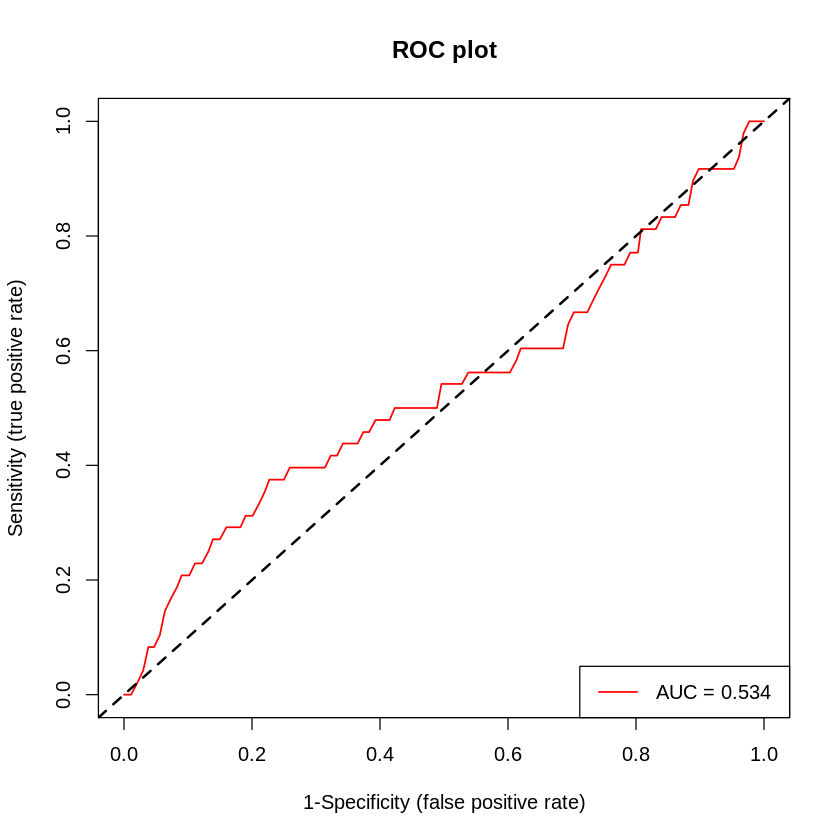

[1] "Modeling:  2 out of  7"


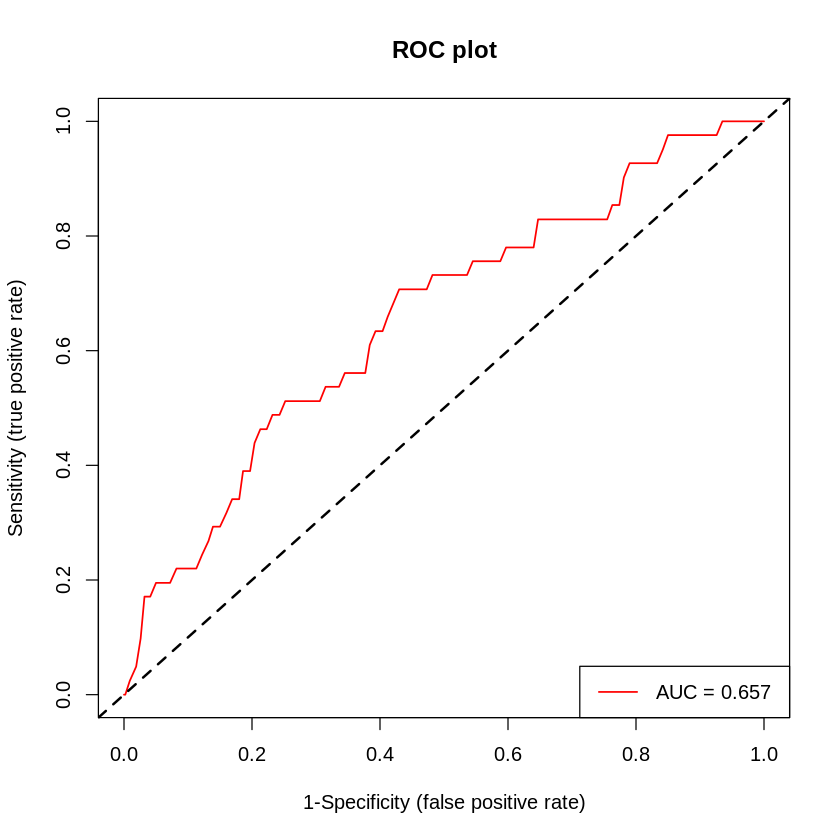

[1] "Modeling:  3 out of  7"


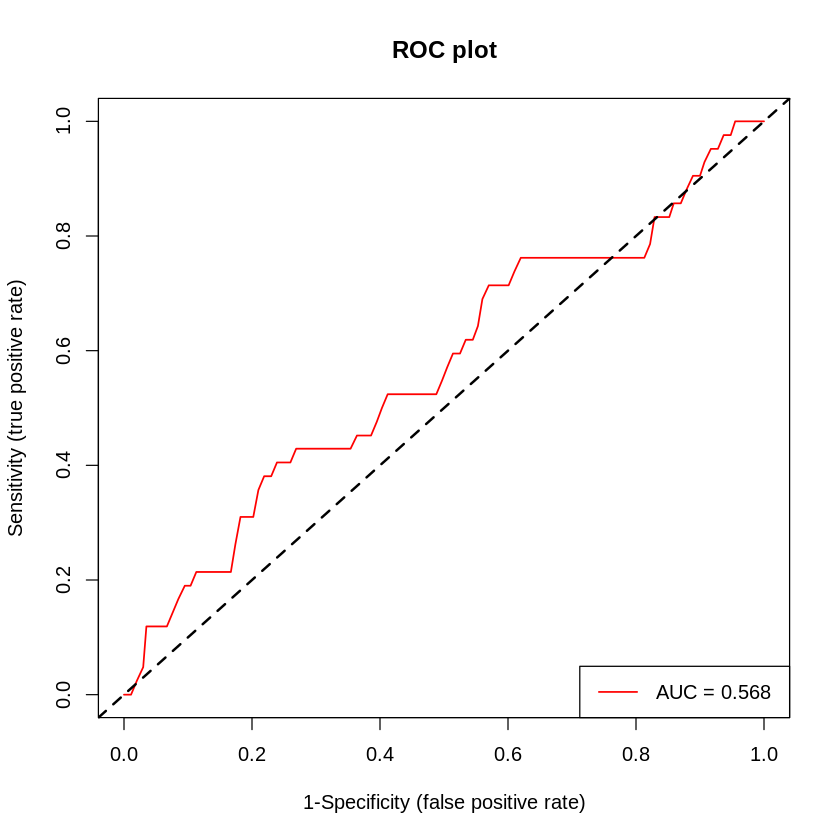

[1] "Modeling:  4 out of  7"


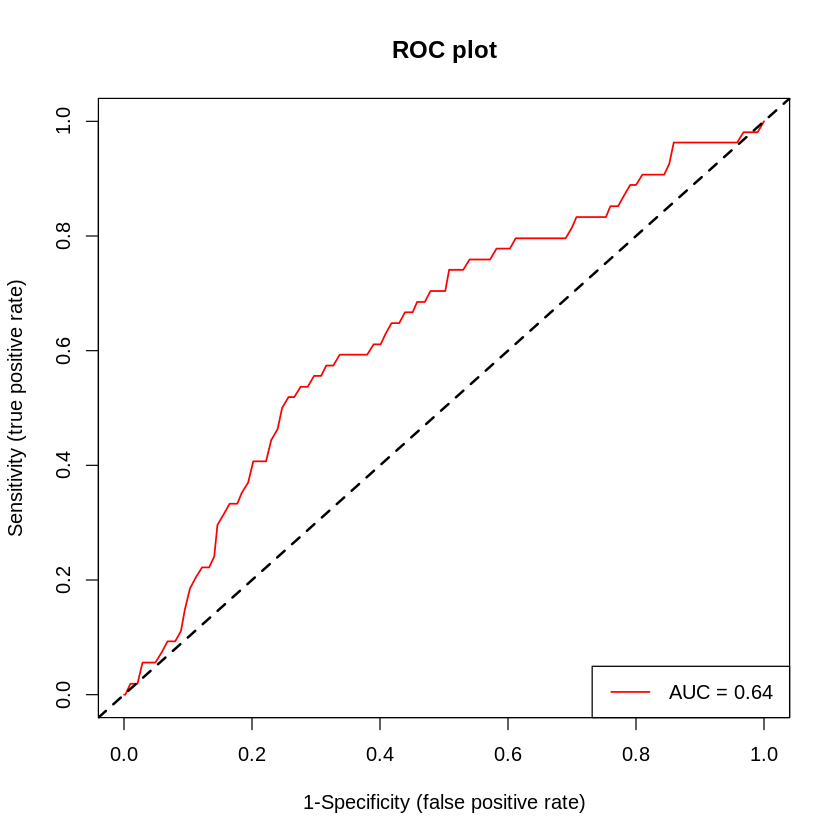

[1] "Modeling:  5 out of  7"


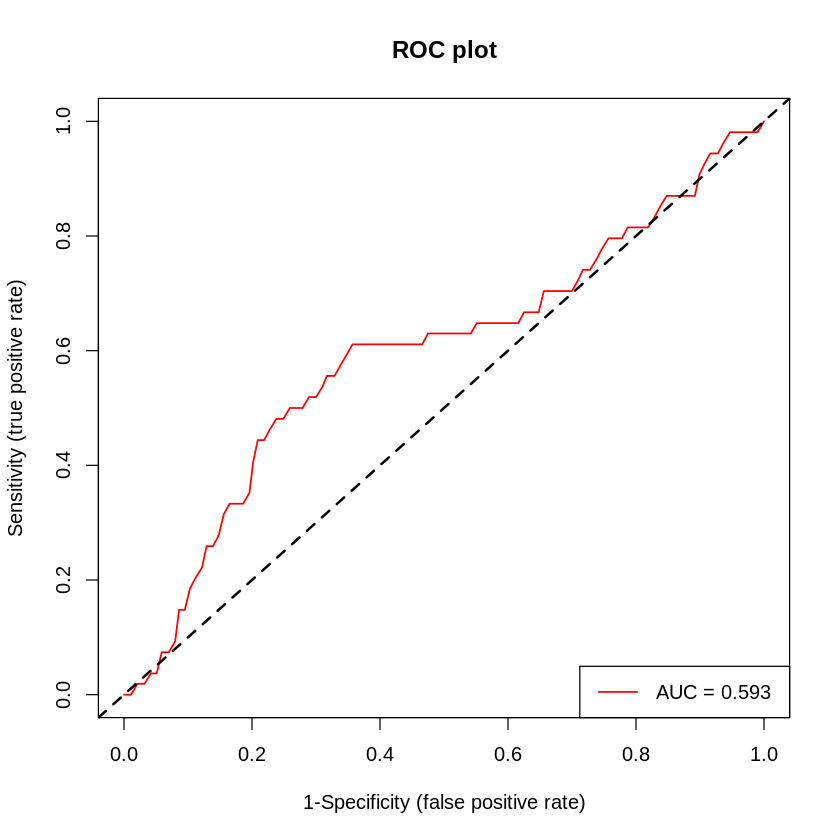

[1] "Modeling:  6 out of  7"


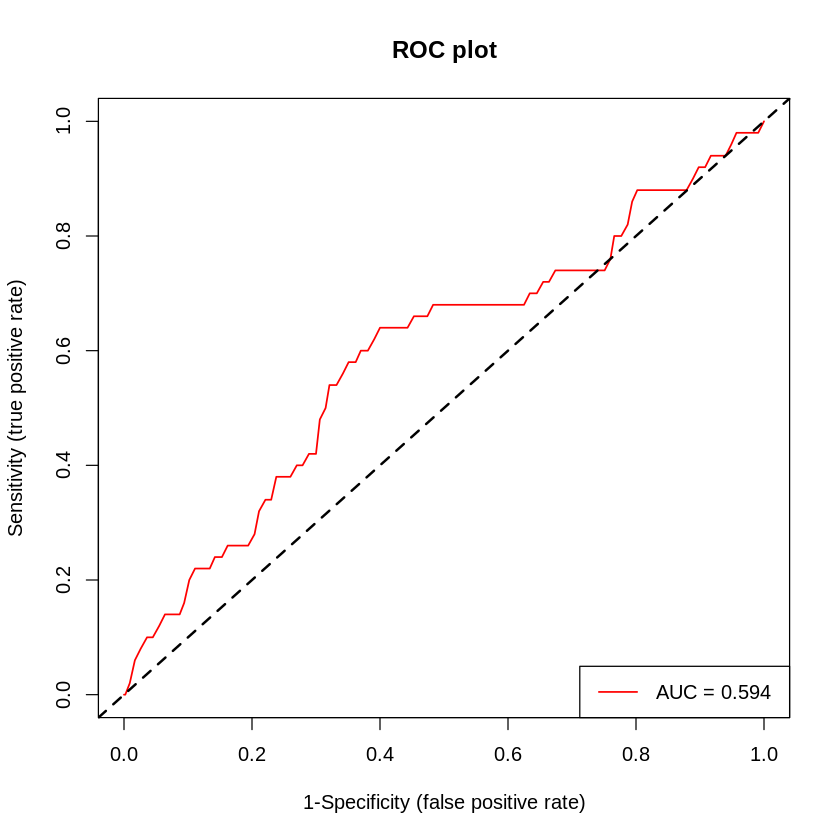

[1] "Modeling:  7 out of  7"


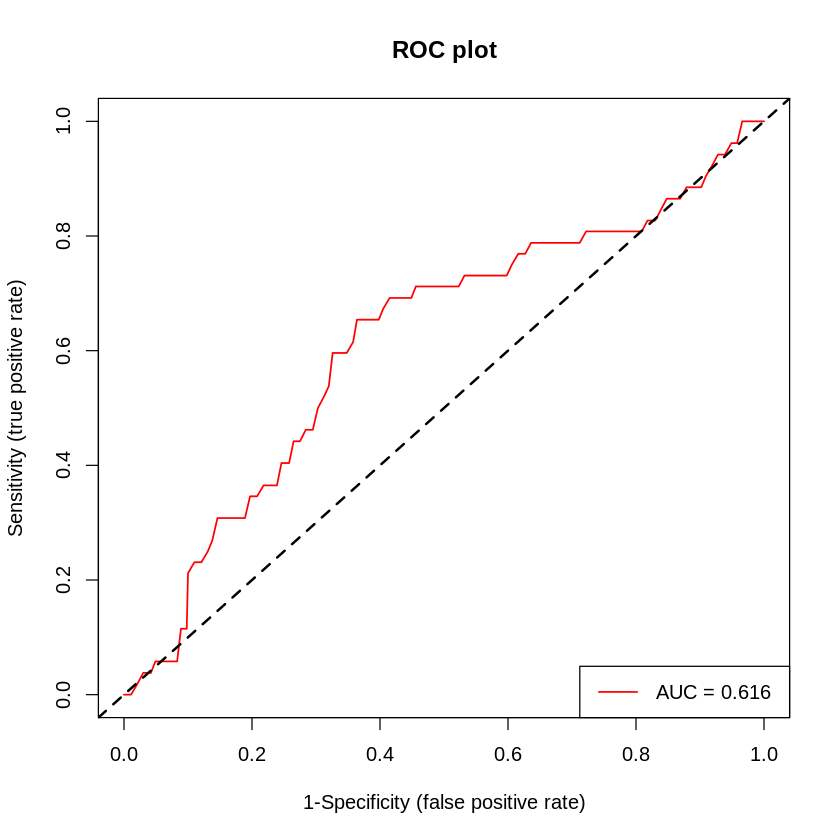

In [34]:
l <- list()
i = 1
DataFrame$predicted_values_CV <- NA
for (fold in validate) {
    
    #predictors = model.frame(formula = '~Elevationm + MeanTempm',data=DataFrame[fold,])
    #train.matrix = model.frame(formula = '~Elevationm + MeanTempm',data=DataFrame[-fold,])
    #predictors = model.frame(formula = '~Elevationm + Precipitationm',data=DataFrame[fold,])
    #train.matrix = model.frame(formula = '~Elevationm + Precipitationm',data=DataFrame[-fold,])
    
    predictors = model.frame(formula = '~Elevationm + Precipitationm + Disttoroadm + Populationm',data=DataFrame[fold,])
    train.matrix = model.frame(formula = '~Elevationm + Precipitationm + Disttoroadm + Populationm',data=DataFrame[-fold,])
    maxentm = maxnet(DataFrame$species[-fold],train.matrix,
                     maxnet.formula(DataFrame$species[-fold],train.matrix,classes='l'))
    
    pred_vals = predict(maxentm,predictors,type='cloglog')
    
    DataFrame$predicted_values_CV[fold] <- pred_vals
    
    pROC_obj <- roc(DataFrame$species[fold],pred_vals)

    l[[i]] <- pROC_obj
    c = paste("Modeling: ",i, "out of ",length(validate))
    print(c)
    i = i + 1
}

Warning message in plot.window(...):
“"smoothed" is not a graphical parameter”Warning message in plot.window(...):
“"ci" is not a graphical parameter”Warning message in plot.window(...):
“"ci.alpha" is not a graphical parameter”Warning message in plot.window(...):
“"stratified" is not a graphical parameter”Warning message in plot.window(...):
“"plot" is not a graphical parameter”Warning message in plot.window(...):
“"auc.polygon" is not a graphical parameter”Warning message in plot.window(...):
“"max.auc.polygon" is not a graphical parameter”Warning message in plot.window(...):
“"grid" is not a graphical parameter”Warning message in plot.window(...):
“"print.auc" is not a graphical parameter”Warning message in plot.window(...):
“"show.thres" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"smoothed" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"ci" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"ci.alpha" is

ERROR: Error in roc.default(response, predictor, ci = FALSE, ...): No valid data provided.


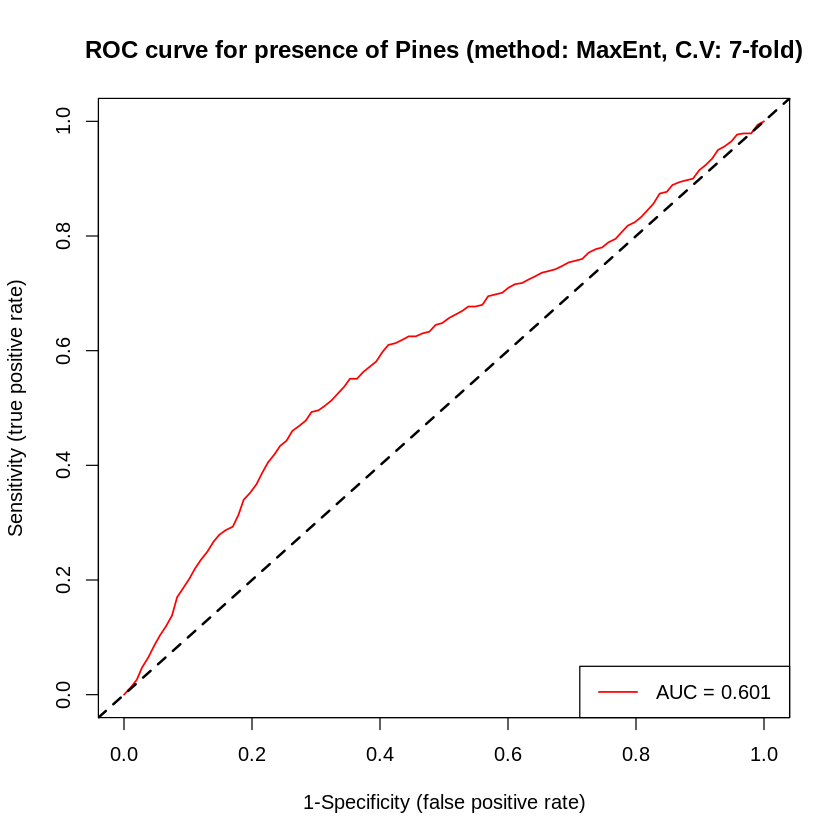

In [35]:
pROC_obj <- roc(DataFrame$species,DataFrame$predicted_values_CV,
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE,main='ROC curve for presence of Pines (method: MaxEnt, C.V: 7-fold)')
sens.ci <- ci.se(pROC_obj)
plot(sens.ci,type="shape",col="lightblue")
plot(sens.ci, type="bars")
